# Introduction

I've decided to build a simple comparison between popular strategies used to work with imbalanced data. Feel free to add any comments!

# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

plt.style.use('ggplot')

# Import Data

In [3]:
hr_data = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
hr_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


# Initial Treatments

Let's remove useless columns

In [6]:
# Removing constants
hr_data = hr_data.loc[:, hr_data.nunique() > 1]

Let's separate the categorical columns. We can do this by selecting those with fewer distinct values, separating objects, or examining each column individually. The first two methods come with risks but are easier and faster than the last one. Additionally, if you have many columns, it's impractical to use the last approach.

In [7]:
target = 'Attrition'
categorical_vars = [x for x in hr_data.select_dtypes(include=['object']).columns if x!=target]
continuous_vars = [x for x in hr_data.select_dtypes(exclude =['object']).columns if x!= target]
print(f'categorical_vars: {categorical_vars}')
print(f'continuous_vars: {continuous_vars}')

categorical_vars: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
continuous_vars: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Let's convert the target to numerical

In [8]:
hr_data['Attrition'] = hr_data['Attrition'].map({'Yes':1, 'No':0})

<Axes: xlabel='Attrition'>

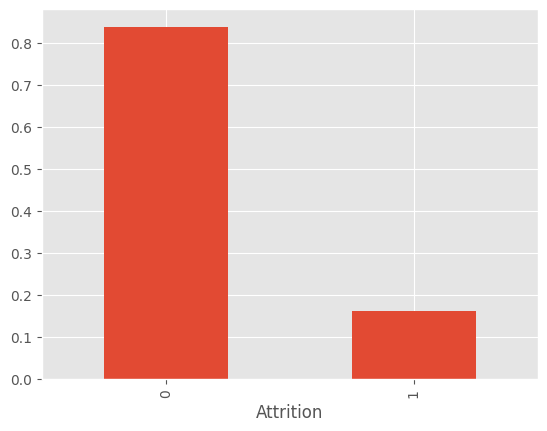

In [9]:
hr_data['Attrition'].value_counts(1).plot.bar()

# EDA

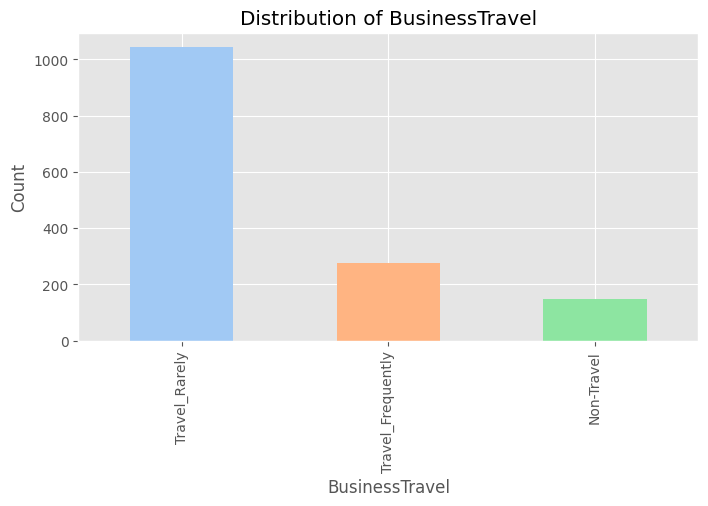

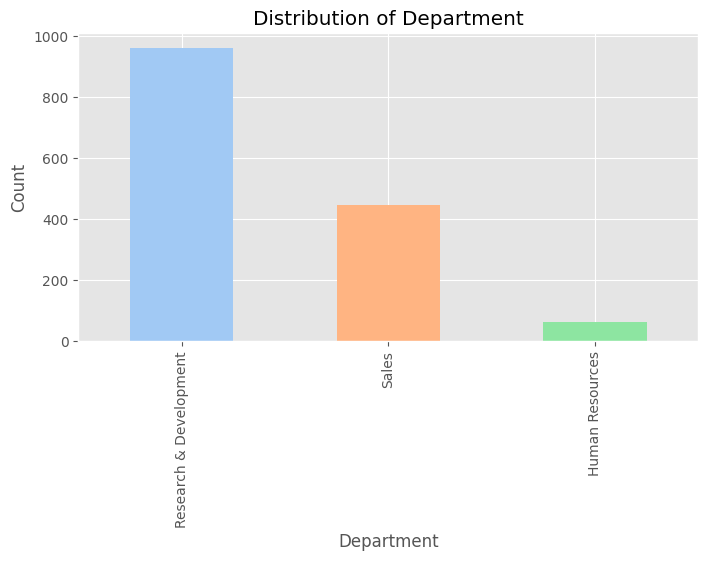

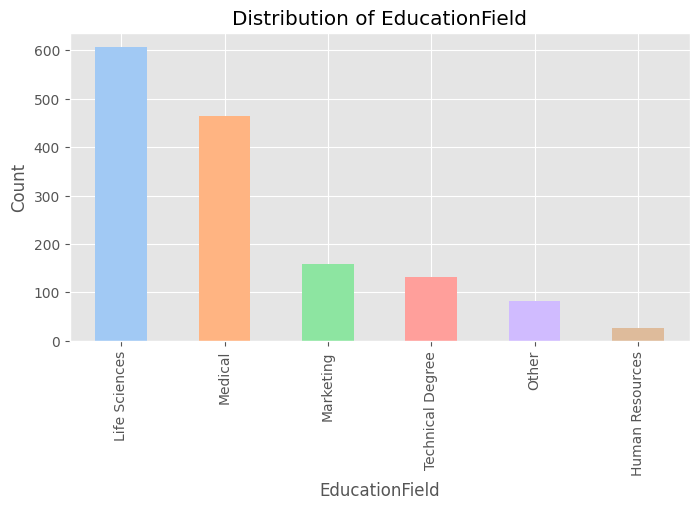

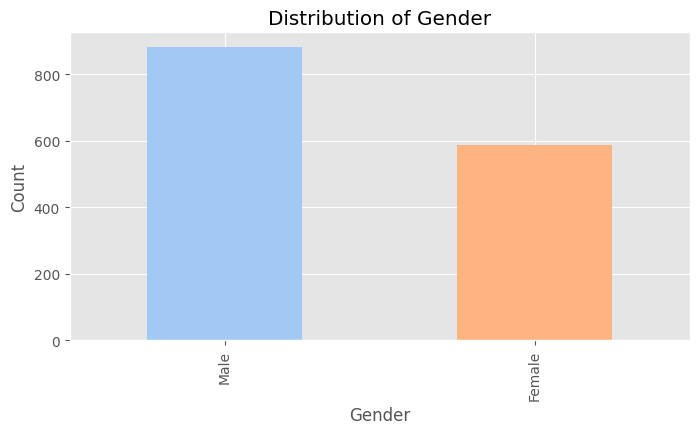

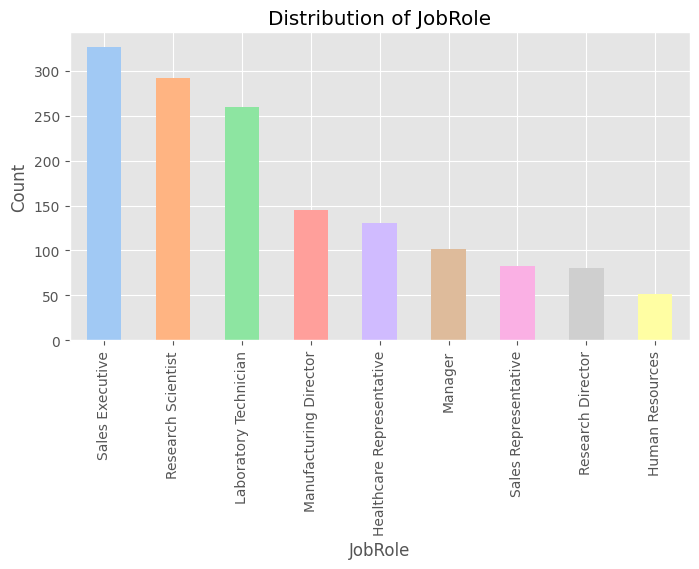

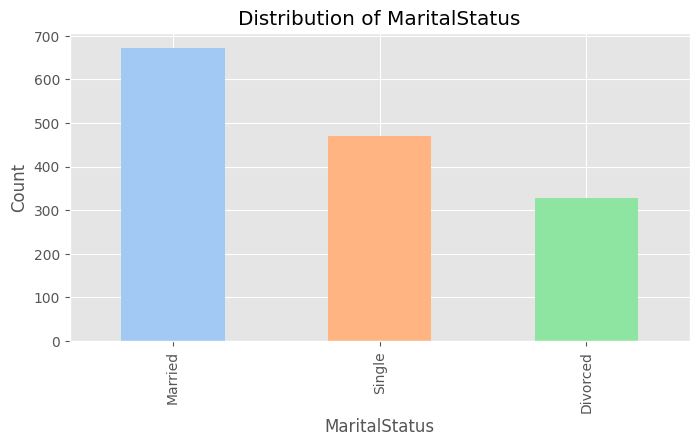

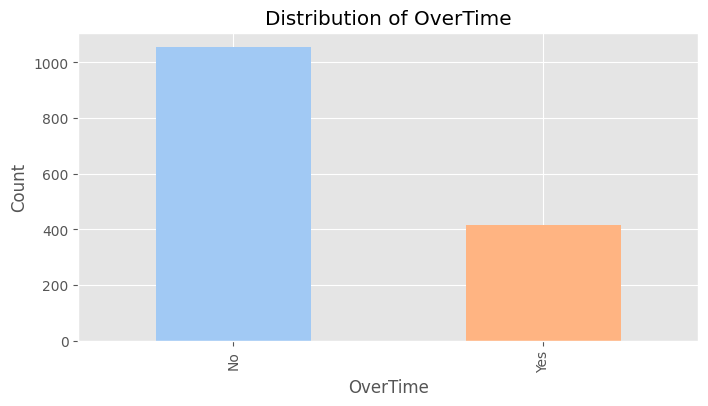

In [10]:
#sns.set_style("white")
colors = sns.color_palette('pastel') 

for var in categorical_vars:
    counts = hr_data[var].value_counts()
    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar', color=colors)
    plt.title(f'Distribution of {var}')
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.xticks(rotation=90)
    plt.show()


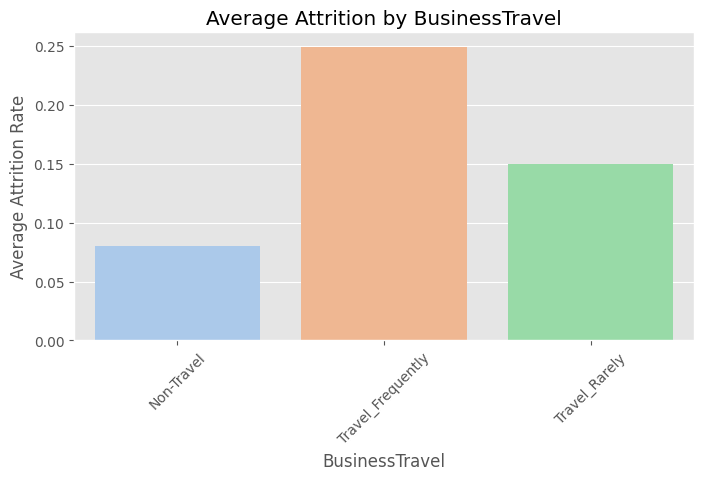

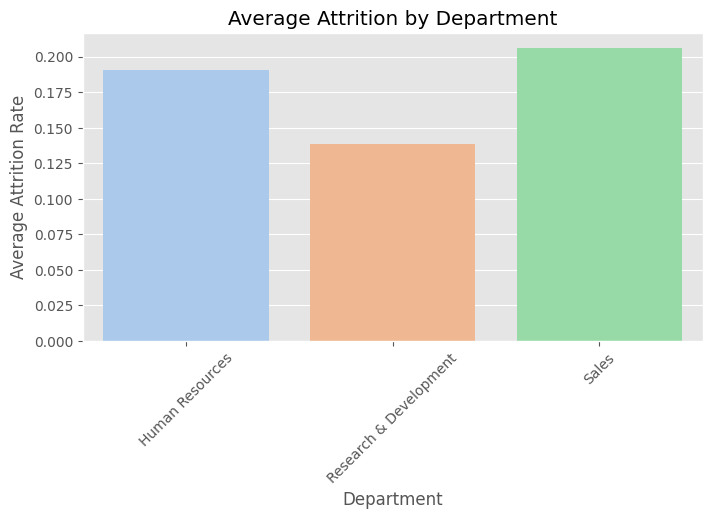

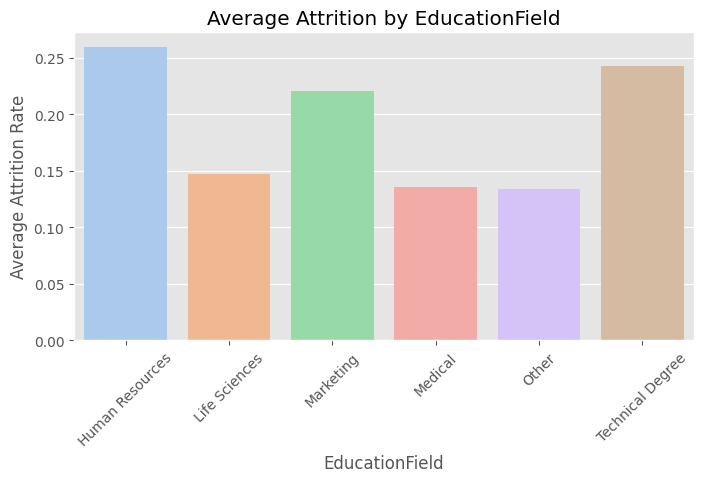

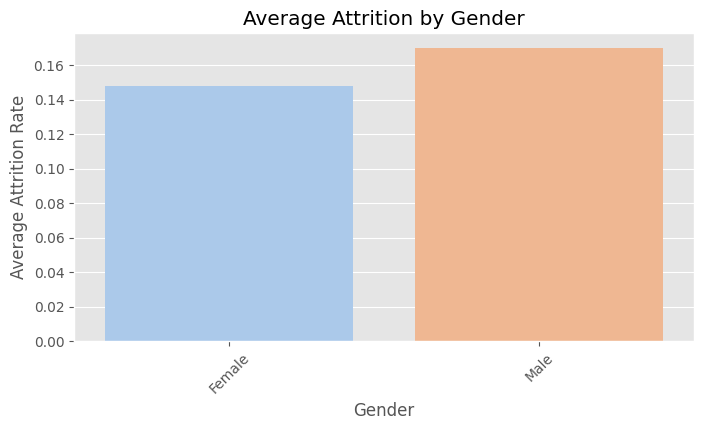

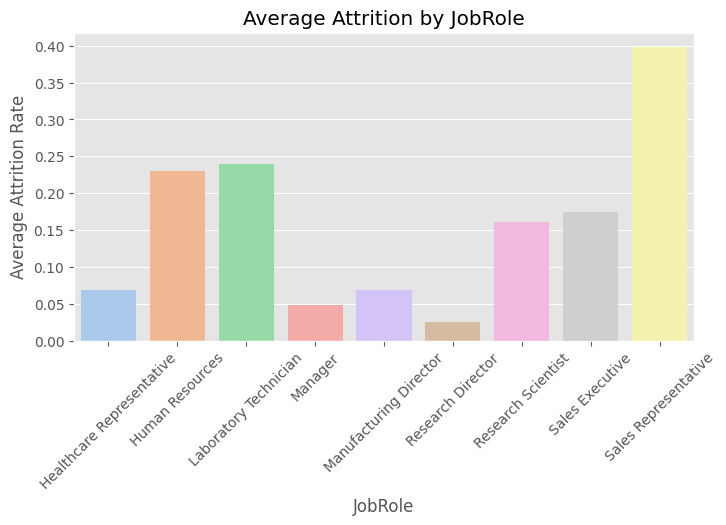

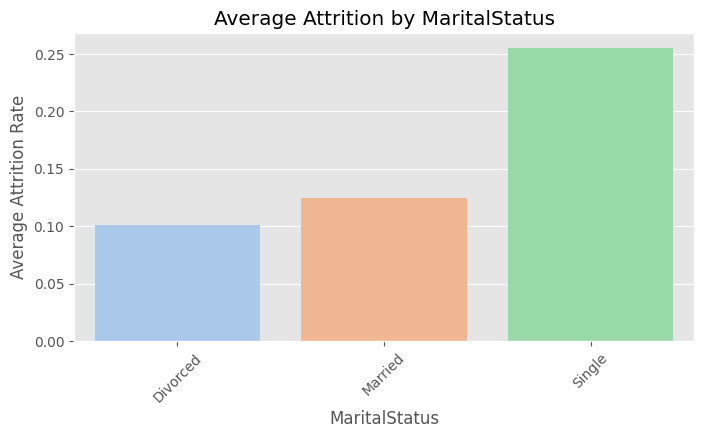

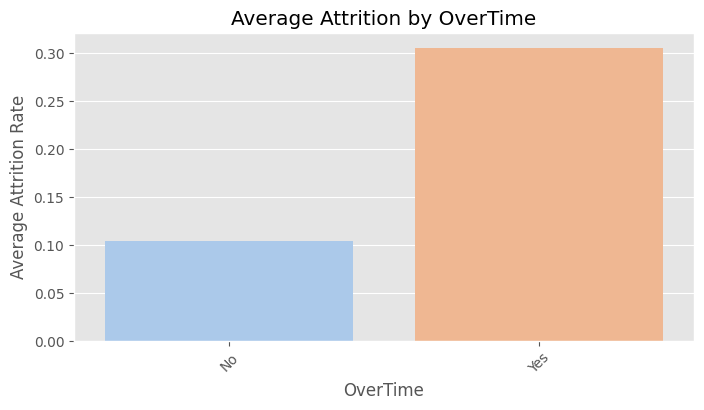

In [11]:
for var in categorical_vars:

    attrition_avg = hr_data.groupby(var)['Attrition'].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.barplot(x=var, y='Attrition', data=attrition_avg, palette='pastel')
    plt.title(f'Average Attrition by {var}')
    plt.ylabel('Average Attrition Rate')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.show()

# ML Model 'Do Nothing'

Let's start by doing nothing in our model.

In [12]:
X = hr_data.drop(['Attrition'], axis=1)
y = hr_data['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
encoder = TargetEncoder(cols=categorical_vars)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [14]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_encoded, y_train)

[LightGBM] [Info] Number of positive: 198, number of negative: 978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1397
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168367 -> initscore=-1.597243
[LightGBM] [Info] Start training from score -1.597243


LGBMClassifier()

In [15]:
# Make predictions
y_pred = lgb_model.predict(X_test_encoded)
y_pred_proba = lgb_model.predict_proba(X_test_encoded)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for ROC AUC
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.8707
ROC AUC: 0.8119
F1 Score: 0.3667
Precision: 0.5238
Recall: 0.2821


# ML Model w Class Weight

This is currently my favourite approach, besides changing the threshold of predict_proba.

In [16]:
# Calculate class weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Create a dictionary with class labels as keys and computed weights as values
class_weight_dict = dict(zip(classes, weights))

# Initialize the LGBM model with class weights
lgb_model = LGBMClassifier(class_weight=class_weight_dict)
lgb_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_encoded)
y_pred_proba = lgb_model.predict_proba(X_test_encoded)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


[LightGBM] [Info] Number of positive: 198, number of negative: 978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1397
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Accuracy: 0.8741
ROC AUC: 0.8178
F1 Score: 0.4638
Precision: 0.5333
Recall: 0.4103


In [17]:
weights

array([0.60122699, 2.96969697])

In [18]:
978/198, 2.96969/0.60122


(4.9393939393939394, 4.939439805728353)

Improved all metrics, specially Recall.

# ML Model w SMOTE

<b>Personal Note:</b> I've never seen SMOTE working in 'real life', but let's see what it does to our model!

<div style="border:1px solid red; padding:10px;">

<b style="color: red;">Attention:</b> <i>Remember to never do oversampling in <code>X_test</code>, since this is the data that is simulating what will happen when your model is in production. I.e., this data will be imbalanced. You need to validate if your model will work when it receives imbalanced data in production.</i>

</div>


In [19]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Supondo que X_train_encoded e X_test_encoded já estejam codificados e prontos para o uso.

# Scaling dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Aplicar SMOTE após o scaling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Treinar o modelo
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_smote, y_train_smote)

# Fazer predições
y_pred = lgb_model.predict(X_test_scaled)
y_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular e imprimir as métricas
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")


[LightGBM] [Info] Number of positive: 978, number of negative: 978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6408
[LightGBM] [Info] Number of data points in the train set: 1956, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8776
ROC AUC: 0.7814
F1 Score: 0.4000
Precision: 0.5714
Recall: 0.3077


As expected, SMOTE didn't improve our metrics. 

# ML Model w CTGAN

I've just learned about conditional GAN. Let's see how it performs!

In [20]:
!pip install ctgan

ERROR: Could not find a version that satisfies the requirement ctgan (from versions: none)
ERROR: No matching distribution found for ctgan


In [21]:
from ctgan import CTGAN
ctgan = CTGAN()

ModuleNotFoundError: No module named 'ctgan'

In [ ]:
y_train.value_counts()

In [ ]:
full_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
full_train.head()

In [ ]:
# Should I do this? Still didn't fully understand CTGAN 'training'
categorical_vars.append('Attrition')

In [ ]:
ctgan.fit(full_train, discrete_columns=(categorical_vars))


In [ ]:
samples = ctgan.sample(1000)

In [ ]:
samples = samples[samples['Attrition'] == 1]


In [ ]:
samples.shape

In [ ]:
ctgan_result_df = pd.concat([full_train,samples])
ctgan_result_df.head()

In [ ]:
ctgan_result_df.Attrition.value_counts()

In [ ]:
X_train_ctgan = ctgan_result_df.drop('Attrition', axis=1)
y_train_ctgan = ctgan_result_df['Attrition']

In [ ]:
categorical_vars = [var for var in categorical_vars if var != 'Attrition']

In [ ]:
X_train_ctgan[categorical_vars]

In [ ]:
encoder = TargetEncoder(cols=categorical_vars)
X_train_ctgan_encoded = encoder.fit_transform(X_train_ctgan, y_train_ctgan)
X_test_encoded = encoder.transform(X_test)


In [ ]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train_ctgan_encoded, y_train_ctgan)

y_pred = lgb_model.predict(X_test_encoded)

y_pred_proba = lgb_model.predict_proba(X_test_encoded)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Unfortunately, it didn't work well. I still need to read the paper and understand what's happening. However, I've decided to use it anyway, so you (perhaps) might learn something new.

# Results

In [ ]:
models = ['Do Nothing', 'Class Weight', 'SMOTE', 'GAN']
metrics = {
    'Accuracy': [0.8707, 0.8741, 0.8776, 0.8639],
    'ROC AUC': [0.8119, 0.8178, 0.7814, 0.7386],
    'F1 Score': [0.3667, 0.4638, 0.4000, 0.3333],
    'Precision': [0.5238, 0.5333, 0.5714, 0.4762],
    'Recall': [0.2821, 0.4103, 0.3077, 0.2564]
}

# Converting to DataFrame for easier plotting
df = pd.DataFrame(metrics, index=models)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
df.plot(kind='bar', ax=ax)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticklabels(models, rotation=45)
plt.legend(title='Metrics', title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.show()
